In [2]:
from BRScraper import nba
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_curve, recall_score, roc_auc_score, accuracy_score
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


In [3]:
# loading the train and test datasets
train_df = pd.read_csv('nba_combined_1980_2015.csv')
test_df = pd.read_csv('nba_combined_2016_2024.csv')

# defining the features
features = [
    'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3P%', '2P', '2P%', 'eFG%',
    'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK',
    'TOV', 'PTS', 'TS%', 'EFF'
]


# Identifies and ranks MVP candidates within each season.
def identify_mvp_candidates(df):
    df = df.copy()
    df['MVP_Rank'] = None  # Rank (1-5) of top MVP candidates

    for season in df['Season'].unique():
        season_mask = df['Season'] == season
        season_data = df[season_mask]

        # Filter nominated players
        nominated_mask = season_data['Nominated'] == 1
        nominated_players = season_data[nominated_mask]

        if len(nominated_players) >= 5:
            # Sort nominated players by EFF, PTS, and AST
            ranked_players = (
                nominated_players.sort_values(
                    by=['EFF', 'PTS', 'AST'], 
                    ascending=[False, False, False]
                )
                .head(5)  # Top 5 candidates
            )
            
            # Assign ranks
            for rank, (idx, _) in enumerate(ranked_players.iterrows(), start=1):
                df.loc[idx, 'MVP_Rank'] = rank

    return df

# storing ranked MVP candidates from the datasets
train_df = identify_mvp_candidates(train_df)
test_df = identify_mvp_candidates(test_df)

# preparing our features and target
X = train_df[features]
y = train_df['MVP_Rank'].notna().astype(int)  # Target is whether a player is in the top 5 (binary classification)

# splitting the data
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42, stratify=y)

# handle missing values and scale features if necessary
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)

# applying SMOTE for class imbalances - Synthetic Minority Oversampling to help balance the datasets
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Training our DummyClassifier model
dummy_clf = DummyClassifier(strategy='stratified', random_state=42)
dummy_clf.fit(X_train_balanced, y_train_balanced)

# validating our predictions
X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
X_val_scaled = scaler.transform(X_val_imputed)

y_pred = dummy_clf.predict(X_val_scaled)
y_pred_proba = dummy_clf.predict_proba(X_val_scaled)[:, 1]  # Probability for class 1

print("\nValidation Set Performance:")
print(f"Recall Score: {recall_score(y_val, y_pred):.3f}")
print(f"ROC-AUC Score: {roc_auc_score(y_val, y_pred_proba):.3f}")

# makes predictions using basic rules, without actually learning from the input data



Validation Set Performance:
Recall Score: 0.639
ROC-AUC Score: 0.573


Recall of 0.639 means that approximately 64% of the actual MVP candidates in the validation set were correctly identified by the model.

Now lets try to predict the top 5 nominees for the MVP award in the 2022-23 season

In [13]:
# predicting and ranking candidates for the 2022-23 season
season_2024 = test_df[test_df['Season'] == '2023-24'].copy()
X_2024 = season_2024[features]
X_2024_imputed = pd.DataFrame(imputer.transform(X_2024), columns=X_2024.columns)
X_2024_scaled = scaler.transform(X_2024_imputed)

pred_proba = dummy_clf.predict_proba(X_2024_scaled)[:, 1]
season_2024['MVP_Probability'] = pred_proba

# retrieving the top 5 predicted MVP candidates
top_5_predictions = season_2024.nlargest(5, 'MVP_Probability')[
    ['Player', 'Team', 'MVP_Probability', 'PTS', 'TRB', 'AST', 'EFF']
].round(3)


print("\nPredicted Top 5 MVP Candidates for 2022-23 Season:")
for rank, (_, row) in enumerate(top_5_predictions.iterrows(), 1):
    print(f"{rank}. {row['Player']} ({row['Team']}):")
    print(f"   MVP Probability: {row['MVP_Probability']}")
    print(f"   Stats: {row['PTS']} PTS, {row['TRB']} REB, {row['AST']} AST")
    print(f"   Efficiency: {row['EFF']}")



Predicted Top 5 MVP Candidates for 2022-23 Season:
1. Joel Embiid (PHI):
   MVP Probability: 1.0
   Stats: 34.7 PTS, 11.0 REB, 5.6 AST
   Efficiency: 0.99
2. Jalen Brunson (NYK):
   MVP Probability: 1.0
   Stats: 28.7 PTS, 3.6 REB, 6.7 AST
   Efficiency: 0.33
3. Devin Booker (PHO):
   MVP Probability: 1.0
   Stats: 27.1 PTS, 4.5 REB, 6.9 AST
   Efficiency: 0.39
4. Kevin Durant (PHO):
   MVP Probability: 1.0
   Stats: 27.1 PTS, 6.6 REB, 5.0 AST
   Efficiency: 0.37
5. Stephen Curry (GSW):
   MVP Probability: 1.0
   Stats: 26.4 PTS, 4.5 REB, 5.1 AST
   Efficiency: 0.31


Compare predictions to actual results

In [14]:
# Get MVP votings from 2023
print(nba.get_award_votings('mvp', 2023).head(5))

  Rank                   Player  Age   Tm  Voting_First  Voting_Pts Won  \
0    1              Joel Embiid   28  PHI            73             915   
1    2             Nikola Jokić   27  DEN            15             674   
2    3    Giannis Antetokounmpo   28  MIL            12             606   
3    4             Jayson Tatum   24  BOS             0             280   
4    5  Shai Gilgeous-Alexander   24  OKC             0              46   

   Voting_Pts Max  Voting_Share   G  Per Game_MP  Per Game_PTS  Per Game_TRB  \
0            1000         0.915  66         34.6          33.1          10.2   
1            1000         0.674  69         33.7          24.5          11.8   
2            1000         0.606  63         32.1          31.1          11.8   
3            1000         0.280  74         36.9          30.1           8.8   
4            1000         0.046  68         35.5          31.4           4.8   

   Per Game_AST  Per Game_STL  Per Game_BLK  Shooting_FG%  Shooting_

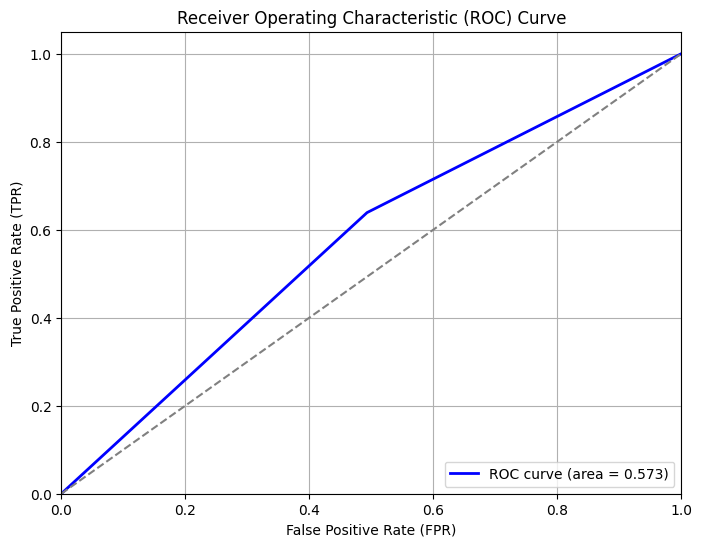

In [15]:
# calculating the ROC curve values
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred)

# plotting ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

ROC-AUC of 0.573 indicates the model is somewhat better than random, but still quite poor at distinguishing between the two classe (non-MVP and MVP).

TEST MODEL CHNAGES BELOW THIS LINE

Testing model improvements after adding the Team_Rank column to the datasets, and implementing LogisticRegression. 

In [16]:
from sklearn.linear_model import LogisticRegression

train_df = pd.read_csv('nba_combined_1980_2015_with_Team_Rank.csv')
test_df = pd.read_csv('nba_combined_2016_2024_with_Team_Rank.csv')

features = [
    'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3P%', '2P', '2P%', 'eFG%',
    'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK',
    'TOV', 'PTS', 'TS%', 'EFF', 'Team_Rank'
]

# filtering for players on high-performing teams (top 6 seeds)
train_df = train_df[train_df['Team_Rank'] <= 6]
test_df = test_df[test_df['Team_Rank'] <= 6]

# Identify and rank MVP candidates
def identify_mvp_candidates(df):
    df = df.copy()
    df['MVP_Rank'] = None  # Rank (1-5) of top MVP candidates

    for season in df['Season'].unique():
        season_mask = df['Season'] == season
        season_data = df[season_mask]

        # filtering nominated players
        nominated_mask = season_data['Nominated'] == 1
        nominated_players = season_data[nominated_mask]

        if len(nominated_players) >= 5:
            # sorting nominated players by EFF, PTS, and AST
            ranked_players = (
                nominated_players.sort_values(
                    by=['EFF', 'PTS', 'AST'],
                    ascending=[False, False, False]
                )
                .head(5)
            )
            
            # assigning the ranks
            for rank, (idx, _) in enumerate(ranked_players.iterrows(), start=1):
                df.loc[idx, 'MVP_Rank'] = rank

    return df


train_df = identify_mvp_candidates(train_df)
test_df = identify_mvp_candidates(test_df)

# preparing the features and target
X = train_df[features]
y = train_df['MVP_Rank'].notna().astype(int)  # Target is binary (1 if top 5 MVP candidate, 0 otherwise)

# splitting the data
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42, stratify=y)

# handling missing values and scale features
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)

# applying SMOTE for class imbalances
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# training our Logistic Regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_balanced, y_train_balanced)

# validating our model
X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)
X_val_scaled = scaler.transform(X_val_imputed)

y_pred = log_reg.predict(X_val_scaled)
y_pred_proba = log_reg.predict_proba(X_val_scaled)[:, 1]  # Probability for class 1

print("\nValidation Set Performance:")
print(f"Accuracy Score: {accuracy_score(y_val, y_pred):.3f}")
print(f"Recall Score: {recall_score(y_val, y_pred):.3f}")
print(f"ROC-AUC Score: {roc_auc_score(y_val, y_pred_proba):.3f}")


Validation Set Performance:
Accuracy Score: 0.941
Recall Score: 0.875
ROC-AUC Score: 0.972


Now lets try predicting again, with the more improved model.

In [17]:
# predicting and rank candidates for the 2022-23 season
season_2024 = test_df[test_df['Season'] == '2023-24'].copy()
X_2024 = season_2024[features]
X_2024_imputed = pd.DataFrame(imputer.transform(X_2024), columns=X_2024.columns)
X_2024_scaled = scaler.transform(X_2024_imputed)

pred_proba = log_reg.predict_proba(X_2024_scaled)[:, 1]
season_2024['MVP_Probability'] = pred_proba

# getting the top 5 predicted MVP candidates
top_5_predictions = season_2024.nlargest(5, 'MVP_Probability')[
    ['Player', 'Team', 'MVP_Probability', 'PTS', 'TRB', 'AST', 'EFF', 'Team_Rank']
].round(3)

print("\nPredicted Top 5 MVP Candidates for 2022-23 Season:")
for rank, (_, row) in enumerate(top_5_predictions.iterrows(), 1):
    print(f"{rank}. {row['Player']} ({row['Team']}):")
    print(f"   MVP Probability: {row['MVP_Probability']}")
    print(f"   Stats: {row['PTS']} PTS, {row['TRB']} REB, {row['AST']} AST")
    print(f"   Efficiency: {row['EFF']}")


Predicted Top 5 MVP Candidates for 2022-23 Season:
1. Nikola Jokić (DEN):
   MVP Probability: 1.0
   Stats: 26.4 PTS, 12.4 REB, 9.0 AST
   Efficiency: 0.49
2. Giannis Antetokounmpo (MIL):
   MVP Probability: 0.983
   Stats: 30.4 PTS, 11.5 REB, 6.5 AST
   Efficiency: 0.5
3. Joel Embiid (PHI):
   MVP Probability: 0.964
   Stats: 34.7 PTS, 11.0 REB, 5.6 AST
   Efficiency: 0.99
4. Desmond Bane (MEM):
   MVP Probability: 0.953
   Stats: 23.7 PTS, 4.4 REB, 5.5 AST
   Efficiency: 0.52
5. Jarrett Allen (CLE):
   MVP Probability: 0.927
   Stats: 16.5 PTS, 10.5 REB, 2.7 AST
   Efficiency: 0.32


In [18]:
# Get MVP votings from 2023
print(nba.get_award_votings('mvp', 2023).head(3))

  Rank                 Player  Age   Tm  Voting_First  Voting_Pts Won  \
0    1            Joel Embiid   28  PHI            73             915   
1    2           Nikola Jokić   27  DEN            15             674   
2    3  Giannis Antetokounmpo   28  MIL            12             606   

   Voting_Pts Max  Voting_Share   G  Per Game_MP  Per Game_PTS  Per Game_TRB  \
0            1000         0.915  66         34.6          33.1          10.2   
1            1000         0.674  69         33.7          24.5          11.8   
2            1000         0.606  63         32.1          31.1          11.8   

   Per Game_AST  Per Game_STL  Per Game_BLK  Shooting_FG%  Shooting_3P%  \
0           4.2           1.0           1.7         0.548         0.330   
1           9.8           1.3           0.7         0.632         0.383   
2           5.7           0.8           0.8         0.553         0.275   

   Shooting_FT%  Advanced_WS  Advanced_WS/48  
0         0.857         12.3          

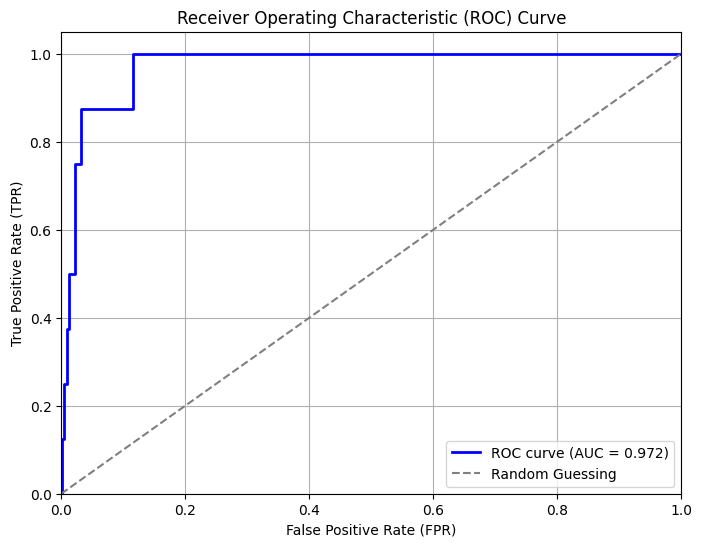

In [19]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
roc_auc = roc_auc_score(y_val, y_pred_proba)

# plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guessing')  # the diagonal line represents random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


While our model is not exactly accurate to real world results, it proves to be another point of view. Showing instead how the MVP ranking should have appeared considering the stats that matter most.